In [ ]:
from transformers import AutoTokenizer, AutoModel

codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def embed_system_code(code_files):
    embeddings = []
    for file in code_files:
        inputs = tokenizer(file, return_tensors="pt", truncation=True, padding=True)
        outputs = codebert_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1))
    return torch.stack(embeddings).mean(dim=0)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
import json
import torch

def embed_notebook_code(file_path, embed_func):
    with open(file_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    code_cells = [
        ''.join(cell['source'])
        for cell in notebook['cells']
        if cell['cell_type'] == 'code'
    ]

    return embed_func(code_cells)



In [ ]:

notebook_path = "/content/drive/MyDrive/DS_dataset/Amazon_product_recommendation/Amazon_recommendation_system.ipynb"
Amazon_Recommendation_System_learner_embedding = embed_notebook_code(notebook_path, embed_system_code)

print("Embedding shape:", Amazon_Recommendation_System_learner_embedding.shape)

notebook_path = "/content/drive/MyDrive/DS_dataset/Spotify_song_recommendation/spotify_weighted_method.ipynb"
Spotify_Recommendation_System_embedding = embed_notebook_code(notebook_path, embed_system_code)

print("Embedding shape:", Spotify_Recommendation_System_embedding.shape)

notebook_path = "/content/drive/MyDrive/DS_dataset/Netflix_content_recommendation /Netflix_Content_Based_Recommedation_System.ipynb"
Netflix_Content_Based_Recommedation_System_embedding = embed_notebook_code(notebook_path, embed_system_code)

print("Embedding shape:", Netflix_Content_Based_Recommedation_System_embedding.shape)

notebook_path = "/content/drive/MyDrive/DS_dataset/Netflix_user_recommendation/Netflix_user_based_.ipynb"
Netflix_user_based_embedding = embed_notebook_code(notebook_path, embed_system_code)

print("Embedding shape:", Netflix_user_based_embedding.shape)

notebook_path = "/content/drive/MyDrive/DS_dataset/Course_recommendation/Coursera_course_recommendation_main_code.ipynb"
Course_Recommendation_embedding = embed_notebook_code(notebook_path, embed_system_code)

print("Embedding shape:", Course_Recommendation_embedding.shape)

Embedding shape: torch.Size([1, 768])
Embedding shape: torch.Size([1, 768])
Embedding shape: torch.Size([1, 768])
Embedding shape: torch.Size([1, 768])
Embedding shape: torch.Size([1, 768])


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

class EnhancedDatasetEmbedder:
    FIXED_FEATURE_ORDER = [
        # Structural (19)
        'num_samples', 'num_features', 'num_numeric_features', 'num_categorical_features',
        'num_datetime_features', 'dtype_ratio', 'attribute_to_instance_ratio',
        'instance_to_attribute_ratio', 'mean_unique_ratio', 'median_unique_ratio',
        'constant_feature_ratio', 'binary_feature_ratio', 'high_cardinality_ratio',
        'missing_value_ratio', 'complete_row_ratio', 'high_missing_ratio',
        'features_with_missing', 'zero_ratio', 'sparse_feature_ratio',

        # Statistical (17)
        'mean_of_means', 'std_of_means', 'mean_of_stds', 'std_of_stds', 'mean_cv',
        'skewness_mean', 'skewness_std', 'kurtosis_mean', 'kurtosis_std',
        'normal_dist_ratio', 'correlation_strength', 'negative_correlation_ratio',
        'strong_correlation_ratio', 'outlier_ratio', 'multivariate_outlier_ratio',
        'temporal_range', 'temporal_granularity',

        # Information-theoretic (6)
        'entropy_mean', 'entropy_std', 'entropy_min', 'entropy_max',
        'high_entropy_ratio', 'low_entropy_ratio',

        # Complexity (8)
        'first_component_variance', 'components_for_90_percent',
        'components_for_95_percent', 'effective_dim_ratio', 'avg_nn_distance',
        'std_nn_distance', 'clustering_inertia', 'cluster_size_variation'
    ]

    def __init__(self, data):
        self.data = data
        self.embedding = None
        self._precompute()

    def _precompute(self):
        self.numeric_data = self.data.select_dtypes(include=np.number)
        self.categorical_data = self.data.select_dtypes(include=['object', 'category'])
        self.datetime_data = self.data.select_dtypes(include='datetime')
        if not self.numeric_data.empty and self.numeric_data.shape[1] > 1:
            self.corr_matrix = self.numeric_data.corr().fillna(0)
        else:
            self.corr_matrix = pd.DataFrame()

    def compute_structural_features(self):
        features = {}
        # Structural feature calculations
        features['num_samples'] = len(self.data)
        features['num_features'] = self.data.shape[1]
        features['num_numeric_features'] = len(self.numeric_data.columns)
        features['num_categorical_features'] = len(self.categorical_data.columns)
        features['num_datetime_features'] = len(self.datetime_data.columns)
        features['dtype_ratio'] = len(self.numeric_data.columns) / max(1, len(self.categorical_data.columns))
        features['attribute_to_instance_ratio'] = self.data.shape[1] / max(1, len(self.data))
        features['instance_to_attribute_ratio'] = len(self.data) / max(1, self.data.shape[1])
        features['mean_unique_ratio'] = self.data.nunique().mean() / max(1, len(self.data))
        features['median_unique_ratio'] = self.data.nunique().median() / max(1, len(self.data))
        features['constant_feature_ratio'] = (self.data.nunique() == 1).mean()
        features['binary_feature_ratio'] = (self.data.nunique() == 2).mean()
        features['high_cardinality_ratio'] = (self.data.nunique() > len(self.data)**0.5).mean()
        features['missing_value_ratio'] = self.data.isna().mean().mean()
        features['complete_row_ratio'] = (self.data.isna().sum(axis=1) == 0).mean()
        features['high_missing_ratio'] = (self.data.isna().mean() > 0.3).mean()
        features['features_with_missing'] = (self.data.isna().mean() > 0).mean()
        features['zero_ratio'] = self.numeric_data.fillna(0).eq(0).mean().mean() if not self.numeric_data.empty else 0
        features['sparse_feature_ratio'] = (self.numeric_data.fillna(0).eq(0).mean() > 0.9).mean() if not self.numeric_data.empty else 0
        return features

    def compute_statistical_features(self):
        features = {}
        # Statistical feature calculations
        if self.numeric_data.empty:
            for key in [k for k in self.FIXED_FEATURE_ORDER if k.startswith('stat_')]:
                features[key] = 0
            return features

        try:
            # Numeric feature calculations
            features['mean_of_means'] = self.numeric_data.mean().mean()
            features['std_of_means'] = self.numeric_data.mean().std()
            features['mean_of_stds'] = self.numeric_data.std().mean()
            features['std_of_stds'] = self.numeric_data.std().std()
            features['mean_cv'] = (self.numeric_data.std() / self.numeric_data.mean().abs()).mean()
            features['skewness_mean'] = self.numeric_data.skew().mean()
            features['skewness_std'] = self.numeric_data.skew().std()
            features['kurtosis_mean'] = self.numeric_data.kurtosis().mean()
            features['kurtosis_std'] = self.numeric_data.kurtosis().std()
            features['normal_dist_ratio'] = self.numeric_data.apply(
                lambda x: normaltest(x.dropna())[1] > 0.05 if len(x.dropna()) > 8 else np.nan
            ).mean()
            features['correlation_strength'] = self.corr_matrix.abs().mean().mean() if not self.corr_matrix.empty else 0
            features['negative_correlation_ratio'] = (self.corr_matrix < -0.5).mean().mean() if not self.corr_matrix.empty else 0
            features['strong_correlation_ratio'] = (self.corr_matrix.abs() > 0.7).mean().mean() if not self.corr_matrix.empty else 0
            features['outlier_ratio'] = self._calculate_outlier_ratio(self.numeric_data)
            features['multivariate_outlier_ratio'] = self._calculate_mahalanobis_outliers(self.numeric_data)
        except Exception as e:
            for key in [k for k in self.FIXED_FEATURE_ORDER if k.startswith('stat_')]:
                features[key] = 0

        # Temporal features
        features['temporal_range'] = 0
        features['temporal_granularity'] = 0
        if not self.datetime_data.empty:
            try:
                features['temporal_range'] = (self.datetime_data.max() - self.datetime_data.min()).mean().total_seconds()
                features['temporal_granularity'] = self.datetime_data.apply(
                    lambda x: x.diff().dt.total_seconds().mode()[0] if not x.diff().dt.total_seconds().empty else np.nan
                ).mean()
            except:
                pass
        return features

    def compute_information_theoretic_features(self):
        features = {}
        # Information-theoretic calculations
        features.update({k:0 for k in self.FIXED_FEATURE_ORDER if k.startswith('info_')})

        if self.data.empty:
            return features

        try:
            def safe_entropy(x):
                counts = x.value_counts()
                return 0 if len(counts) <= 1 else entropy(counts)

            entropies = self.data.apply(lambda x: safe_entropy(x.dropna()))
            features['entropy_mean'] = entropies.mean()
            features['entropy_std'] = entropies.std()
            features['entropy_min'] = entropies.min()
            features['entropy_max'] = entropies.max()
            features['high_entropy_ratio'] = (entropies > np.log(10)).mean()
            features['low_entropy_ratio'] = (entropies < np.log(2)).mean()
        except:
            pass

        return features

    def compute_complexity_features(self):
        features = {}
        # Complexity calculations
        features.update({k:0 for k in self.FIXED_FEATURE_ORDER if k.startswith('complex_')})

        if self.numeric_data.empty or self.numeric_data.shape[1] < 2:
            return features

        try:
            X = StandardScaler().fit_transform(self.numeric_data.fillna(0))

            # PCA analysis
            pca = PCA().fit(X)
            explained_variance_ratio = pca.explained_variance_ratio_
            cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

            features['first_component_variance'] = explained_variance_ratio[0]
            features['components_for_90_percent'] = (
                np.argmax(cumulative_variance_ratio >= 0.9) + 1
                if any(cumulative_variance_ratio >= 0.9)
                else len(cumulative_variance_ratio)
            ) / len(explained_variance_ratio)

            features['components_for_95_percent'] = (
                np.argmax(cumulative_variance_ratio >= 0.95) + 1
                if any(cumulative_variance_ratio >= 0.95)
                else len(cumulative_variance_ratio)
            ) / len(explained_variance_ratio)

            features['effective_dim_ratio'] = sum(explained_variance_ratio > 0.05) / len(explained_variance_ratio)

            # Nearest neighbors analysis
            n_neighbors = min(10, len(X)-1)
            if n_neighbors > 0:
                nn = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
                distances, _ = nn.kneighbors(X)
                features['avg_nn_distance'] = distances.mean()
                features['std_nn_distance'] = distances.std()
            else:
                features['avg_nn_distance'] = 0
                features['std_nn_distance'] = 0

            # Clustering analysis
            if len(X) > 2:
                kmeans = KMeans(n_clusters=min(5, len(X)-1)).fit(X)
                features['clustering_inertia'] = kmeans.inertia_ / len(X)
                cluster_sizes = np.bincount(kmeans.labels_)
                features['cluster_size_variation'] = (
                    cluster_sizes.std() / cluster_sizes.mean()
                    if cluster_sizes.mean() > 0
                    else 0
                )
            else:
                features['clustering_inertia'] = 0
                features['cluster_size_variation'] = 0

        except Exception as e:
            pass

        return features

    def _calculate_outlier_ratio(self, numeric_data):
        try:
            q1 = numeric_data.quantile(0.25)
            q3 = numeric_data.quantile(0.75)
            iqr = q3 - q1
            return ((numeric_data < (q1 - 1.5*iqr)) | (numeric_data > (q3 + 1.5*iqr))).mean().mean()
        except:
            return 0

    def _calculate_mahalanobis_outliers(self, numeric_data):
        try:
            non_constant = numeric_data.loc[:, numeric_data.std() > 0].dropna()
            if non_constant.empty or len(non_constant.columns) < 2:
                return 0

            X = StandardScaler().fit_transform(non_constant)
            cov = np.cov(X, rowvar=False)
            inv_cov = np.linalg.pinv(cov)
            mean_vec = np.mean(X, axis=0)

            dists = [np.sqrt((x - mean_vec) @ inv_cov @ (x - mean_vec).T)
                    for x in X if not np.isnan(x).any()]

            return np.mean(np.array(dists) > 3) if len(dists) > 0 else 0
        except:
            return 0

    def create_dataset_embedding(self):
        features = {}
        features.update(self.compute_structural_features())
        features.update(self.compute_statistical_features())
        features.update(self.compute_information_theoretic_features())
        features.update(self.compute_complexity_features())

        # Validate feature count
        fixed_array = np.array([features.get(f, 0) for f in self.FIXED_FEATURE_ORDER])
        if len(fixed_array) != len(self.FIXED_FEATURE_ORDER):
            missing = set(self.FIXED_FEATURE_ORDER) - set(features.keys())
            extra = set(features.keys()) - set(self.FIXED_FEATURE_ORDER)
            raise RuntimeError(
                f"Feature mismatch! Missing: {missing}, Extra: {extra}"
            )

        # Normalize features
        normalized = (fixed_array - fixed_array.mean()) / fixed_array.std()
        if np.isnan(normalized).any():
            normalized = np.nan_to_num(normalized)

        return normalized


In [ ]:
def get_dataset_embedding(file_path, on_bad_lines='skip'):
    data = pd.read_csv(file_path, low_memory=False, on_bad_lines=on_bad_lines)
    data = data.sample(n=250, random_state=42)
    embedder = EnhancedDatasetEmbedder(data)
    embedding = embedder.create_dataset_embedding()
    return embedding

In [ ]:
Amazon_product_dataset_embedding = get_dataset_embedding(
    '/content/drive/MyDrive/DS_dataset/Amazon_product_recommendation/books_metadata_large.csv',
    on_bad_lines='skip')

Course_dataset_embedding = get_dataset_embedding(
    '/content/drive/MyDrive/DS_dataset/Course_recommendation/Coursera.csv',
    on_bad_lines='skip')

Netflix_content_dataset_embedding = get_dataset_embedding(
    '/content/drive/MyDrive/DS_dataset/Netflix_content_recommendation /netflix_dataset.csv',
    on_bad_lines='skip')

Spotify_dataset_embedding = get_dataset_embedding(
    '/content/drive/MyDrive/DS_dataset/Spotify_song_recommendation/data.csv',
    on_bad_lines='skip')

Netflix_user_dataset_embedding = get_dataset_embedding(
    '/content/drive/MyDrive/DS_dataset/Netflix_user_recommendation/merge_data.csv',
    on_bad_lines='skip')

In [ ]:
Amazon_product_dataset_embedding
Course_dataset_embedding
Netflix_content_dataset_embedding
Spotify_dataset_embedding
Netflix_user_dataset_embedding

array([-0.1721745 , -0.24248909, -0.24354911, -0.2594494 , -0.26050942,
       -0.25485598, -0.26043733, -0.25877736, -0.26031446, -0.26026208,
       -0.26050942, -0.26050942, -0.260163  , -0.26050942, -0.26015608,
       -0.26050942, -0.26050942, -0.26050933, -0.26050942,  1.01311283,
        2.11799579,  3.00286939,  5.69395529, -0.25995214, -0.25958471,
       -0.25941239, -0.25326927, -0.25327123, -0.26050942, -0.26032924,
       -0.26050942, -0.2603901 , -0.2604737 , -0.26016738, -0.26050942,
       -0.26050942, -0.25896557, -0.26012478, -0.25993834, -0.25855846,
       -0.26016993, -0.26050942, -0.26050942, -0.26050942, -0.26050942,
       -0.26050942, -0.26050942, -0.26050942, -0.26050942, -0.26050942])

In [ ]:
print("Amazon_product_dataset_embedding length: ",len(Amazon_product_dataset_embedding))
print("Course_dataset_embedding length: ",len(Course_dataset_embedding))
print("Netflix_content_dataset_embedding length: ",len(Netflix_content_dataset_embedding))
print("Spotify_dataset_embedding length: ",len(Spotify_dataset_embedding))
print("Netflix_user_dataset_embedding length: ",len(Netflix_user_dataset_embedding))

Amazon_product_dataset_embedding length:  50
Course_dataset_embedding length:  50
Netflix_content_dataset_embedding length:  50
Spotify_dataset_embedding length:  50
Netflix_user_dataset_embedding length:  50


In [ ]:

# notebook_path = "/content/drive/MyDrive/DS_dataset/Amazon_product_recommendation/Amazon_recommendation_system.ipynb"
# Amazon_Recommendation_System_learner_embedding = embed_notebook_code(notebook_path, embed_system_code)

# print("Embedding shape:", Amazon_Recommendation_System_learner_embedding.shape)

# notebook_path = "/content/drive/MyDrive/DS_dataset/Spotify_song_recommendation/spotify_weighted_method.ipynb"
# Spotify_Recommendation_System_embedding = embed_notebook_code(notebook_path, embed_system_code)

# print("Embedding shape:", Spotify_Recommendation_System_embedding.shape)

# notebook_path = "/content/drive/MyDrive/DS_dataset/Netflix_content_recommendation /Netflix_Content_Based_Recommedation_System.ipynb"
# Netflix_Content_Based_Recommedation_System_embedding = embed_notebook_code(notebook_path, embed_system_code)

# print("Embedding shape:", Netflix_Content_Based_Recommedation_System_embedding.shape)

# notebook_path = "/content/drive/MyDrive/DS_dataset/Netflix_user_recommendation/Netflix_user_based_.ipynb"
# Netflix_user_based_embedding = embed_notebook_code(notebook_path, embed_system_code)

# print("Embedding shape:", Netflix_user_based_embedding.shape)

# notebook_path = "/content/drive/MyDrive/DS_dataset/Course_recommendation/Coursera_course_recommendation_main_code.ipynb"
# Course_Recommendation_embedding = embed_notebook_code(notebook_path, embed_system_code)

# print("Embedding shape:", Course_Recommendation_embedding.shape)

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

dataset_vectors = np.array([
    Amazon_product_dataset_embedding,
    Course_dataset_embedding,
    Netflix_content_dataset_embedding,
    Spotify_dataset_embedding,
    Netflix_user_dataset_embedding
], dtype=np.float32)

recommendation_vectors = np.array([
    Amazon_Recommendation_System_learner_embedding.detach().numpy().flatten(),
    Course_Recommendation_embedding.detach().numpy().flatten(),
    Netflix_Content_Based_Recommedation_System_embedding.detach().numpy().flatten(),
    Spotify_Recommendation_System_embedding.detach().numpy().flatten(),
    Netflix_user_based_embedding.detach().numpy().flatten()
], dtype=np.float32)

# Normalize the data
input_scaler = StandardScaler()
dataset_vectors = input_scaler.fit_transform(dataset_vectors)

output_scaler = StandardScaler()
recommendation_vectors = output_scaler.fit_transform(recommendation_vectors)

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

def test_recommender_selector(new_dataset_path, model, recommendation_vectors, rec_system_names, embedder_class=None):
    # Load the dataset
    print(f"Loading dataset from: {new_dataset_path}")
    try:
        new_data = pd.read_csv(new_dataset_path)
        print(f"Dataset loaded successfully with shape: {new_data.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    # Generate dataset embedding
    print("Generating dataset embedding...")
    if embedder_class is not None:
        embedder = embedder_class(new_data)
        dataset_vector = embedder.create_dataset_embedding()
        print(f"Dataset embedding generated with length: {len(dataset_vector)}")
    else:
        print("Warning: No embedder class provided. Using a random embedding for demonstration.")
        dataset_vector = np.random.rand(50)  # Default 50D embedding

    # Make prediction using the model
    print("Predicting recommendation system...")
    model.eval()  # evaluation mode
    with torch.no_grad():
        if isinstance(dataset_vector, np.ndarray):
            input_tensor = torch.FloatTensor(dataset_vector.reshape(1, -1))
        else:
            input_tensor = dataset_vector.reshape(1, -1)

        # Get prediction
        prediction = model(input_tensor).numpy()[0]

    # Calculate similarities with all recommendation systems
    similarities = []
    for i, rec_vector in enumerate(recommendation_vectors):
        sim = cosine_similarity(prediction.reshape(1, -1), rec_vector.reshape(1, -1))[0][0]
        similarities.append((rec_system_names[i], sim))

    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Calculate similarity gap (difference between best and second best)
    similarity_gap = similarities[0][1] - similarities[1][1]

    # Prepare and return results
    results = {
        'dataset_path': new_dataset_path,
        'recommended_system': similarities[0][0],
        'confidence': similarities[0][1],
        'similarity_gap': similarity_gap,
        'all_similarities': similarities,
        'prediction_vector': prediction
    }

    # Print results
    print("\n===== Recommendation Results =====")
    print(f"Best recommendation: {similarities[0][0]} (confidence: {similarities[0][1]:.4f})")
    print(f"Second best: {similarities[1][0]} (confidence: {similarities[1][1]:.4f})")
    print(f"Similarity gap: {similarity_gap:.4f}")
    print("\nAll systems ranked by similarity:")
    for system, score in similarities:
        print(f"  {system}: {score:.4f}")

    return results

# Plotting function to visualize recommendation results
def plot_recommendation_results(results):
    """
    Visualize recommendation results with a bar chart.
    """
    import matplotlib.pyplot as plt

    systems = [sys for sys, _ in results['all_similarities']]
    scores = [score for _, score in results['all_similarities']]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(systems, scores, color='skyblue')

    bars[0].set_color('green')

    plt.title(f'Recommendation System Similarity Scores\nSelected: {results["recommended_system"]} (Gap: {results["similarity_gap"]:.4f})')
    plt.xlabel('Recommendation Systems')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Epoch 0/300, Loss: 0.5498, Avg Similarity: -0.0036
Epoch 50/300, Loss: 0.0596, Avg Similarity: 0.7620
Epoch 100/300, Loss: 0.0000, Avg Similarity: 0.8227
Epoch 150/300, Loss: 0.0000, Avg Similarity: 0.8372
Epoch 200/300, Loss: 0.0641, Avg Similarity: 0.8147
Epoch 250/300, Loss: 0.0000, Avg Similarity: 0.8677
Epoch 299/300, Loss: 0.0014, Avg Similarity: 0.8653

Total Training Time: 2.47 seconds

Total Inference Time: 0.0007 seconds


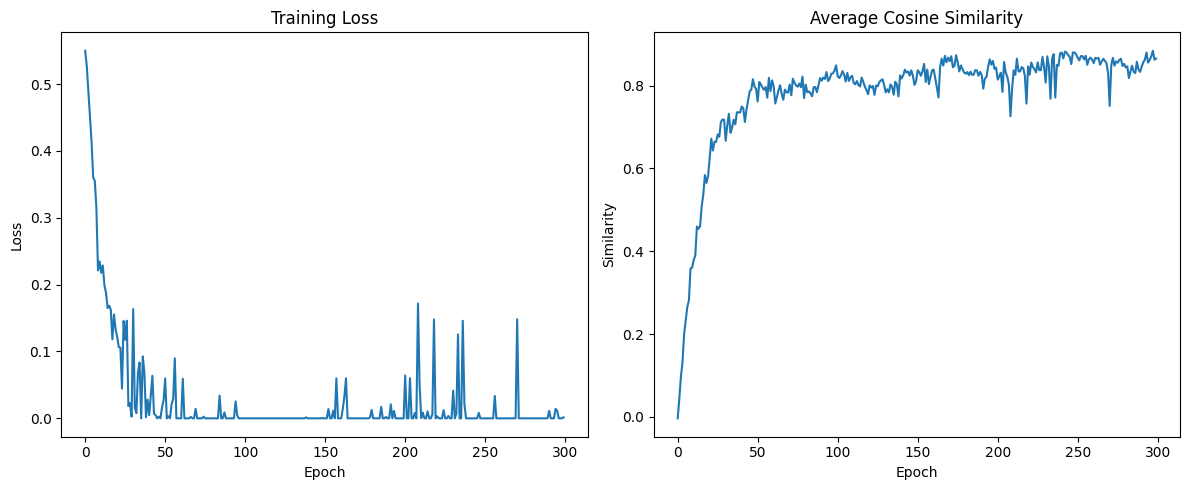

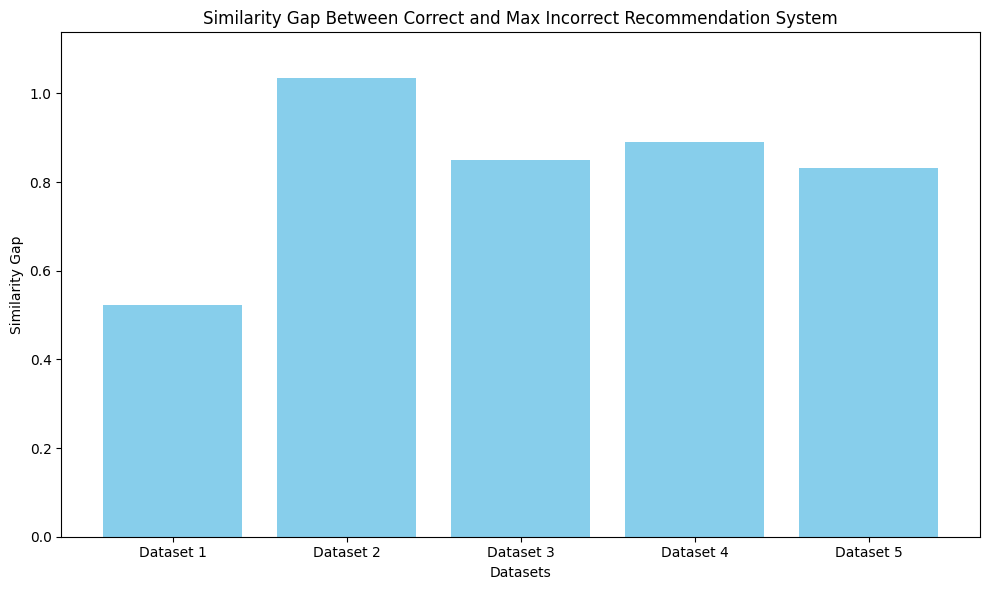

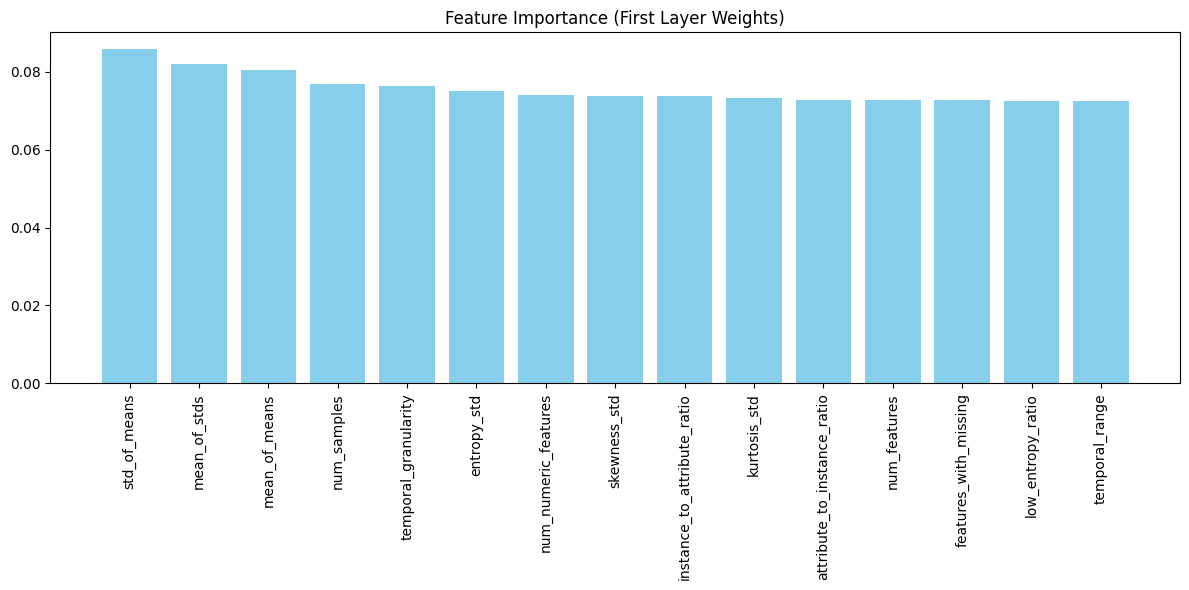

Dataset 1:
  Correct similarity: 0.8418
  Max incorrect similarity: 0.3184
  Similarity gap: 0.5234
Dataset 2:
  Correct similarity: 0.8806
  Max incorrect similarity: -0.1538
  Similarity gap: 1.0343
Dataset 3:
  Correct similarity: 0.9099
  Max incorrect similarity: 0.0596
  Similarity gap: 0.8503
Dataset 4:
  Correct similarity: 0.9054
  Max incorrect similarity: 0.0157
  Similarity gap: 0.8897
Dataset 5:
  Correct similarity: 0.9409
  Max incorrect similarity: 0.1099
  Similarity gap: 0.8309
Loading dataset from: /content/drive/MyDrive/DS_dataset/Testing datasets/apple_music_dataset.csv
Dataset loaded successfully with shape: (10000, 24)
Generating dataset embedding...
Dataset embedding generated with length: 50
Predicting recommendation system...

===== Recommendation Results =====
Best recommendation: Spotify (confidence: 0.8331)
Second best: Netflix Content (confidence: 0.2200)
Similarity gap: 0.6131

All systems ranked by similarity:
  Spotify: 0.8331
  Netflix Content: 0.2200


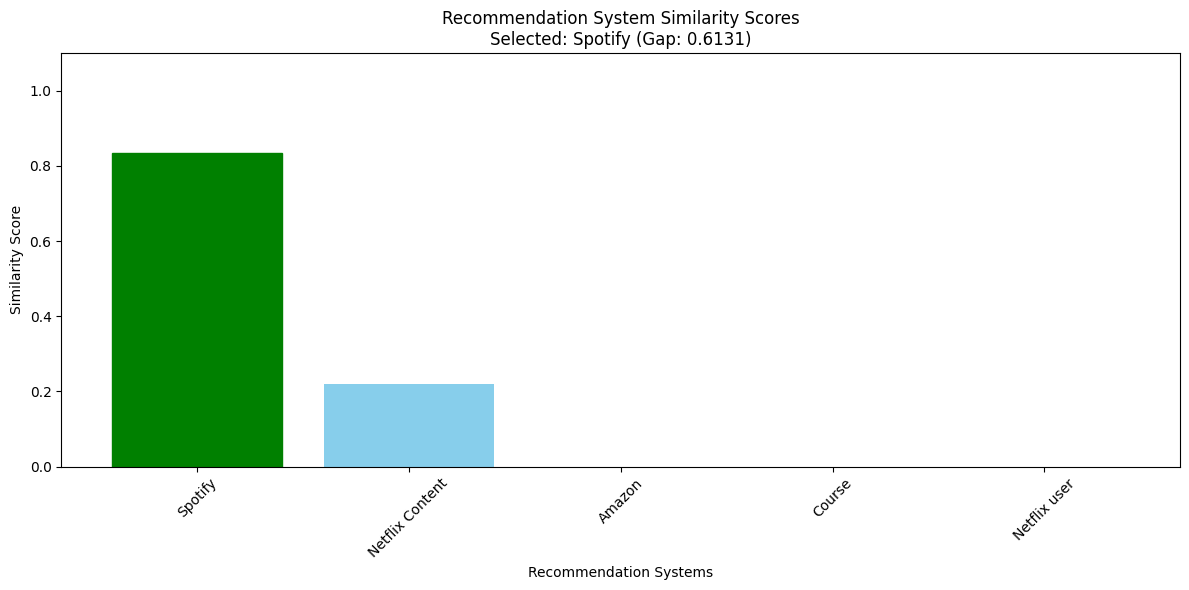

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import time

class NN(nn.Module):
    def __init__(self, input_dim=50, hidden_dim=256, output_dim=768, dropout_rate=0.3):
        super(NN, self).__init__()

        # First layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)

        # Residual block 1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)

        # Output projection
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initial projection
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Residual block 1
        identity = x
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.ln3(x)
        x = x + identity  # Residual connection
        x = F.relu(x)

        # Output projection
        x = self.fc_out(x)

        return x

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.FloatTensor(X)
            return self.forward(X).numpy()

# Contrastive loss function for training
def contrastive_loss(predictions, targets, margin=0.5):
    """
    Compute contrastive loss to maximize similarity with correct targets
    and minimize similarity with incorrect targets
    """
    batch_size = predictions.size(0)

    # Compute cosine similarity matrix
    norm_pred = F.normalize(predictions, p=2, dim=1)
    norm_targets = F.normalize(targets, p=2, dim=1)
    sim_matrix = torch.mm(norm_pred, norm_targets.t())

    pos_sim = torch.diag(sim_matrix)

    mask = torch.ones_like(sim_matrix) - torch.eye(batch_size, device=sim_matrix.device)
    neg_sim = sim_matrix * mask

    max_neg_sim, _ = torch.max(neg_sim, dim=1)

    # Contrastive loss: maximize positive similarity, minimize negative similarity
    loss = torch.mean(torch.relu(max_neg_sim - pos_sim + margin))

    return loss

# Training function
def train_model(dataset_vectors, recommendation_vectors, model, epochs=300, lr=0.001, margin=0.5):
    start_time = time.time()
    X = torch.FloatTensor(dataset_vectors)
    y = torch.FloatTensor(recommendation_vectors)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'loss': [], 'similarity': []}
    model.train()
    for epoch in range(epochs):
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X)

        # Compute loss
        loss = contrastive_loss(outputs, y, margin=margin)

        # Backward pass
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())

        with torch.no_grad():
            pred_numpy = outputs.detach().numpy()
            target_numpy = y.detach().numpy()
            similarities = [cosine_similarity(p.reshape(1, -1), t.reshape(1, -1))[0][0]
                           for p, t in zip(pred_numpy, target_numpy)]
            history['similarity'].append(np.mean(similarities))

        if epoch % 50 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Avg Similarity: {history['similarity'][-1]:.4f}")
    total_training_time = time.time() - start_time
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
    return model, history

def evaluate_model(model, dataset_vectors, recommendation_vectors):
    model.eval()
    start_inference = time.time()
    predictions = model.predict(dataset_vectors)
    inference_time = time.time() - start_inference
    print(f"\nTotal Inference Time: {inference_time:.4f} seconds")
    results = []
    for i in range(len(dataset_vectors)):
        prediction = predictions[i]
        similarities = [cosine_similarity(prediction.reshape(1, -1),
                                         rec.reshape(1, -1))[0][0]
                       for rec in recommendation_vectors]

        correct_sim = similarities[i]
        max_incorrect_sim = max(sim for j, sim in enumerate(similarities) if j != i)
        gap = correct_sim - max_incorrect_sim

        results.append({
            'dataset_idx': i,
            'correct_similarity': correct_sim,
            'max_incorrect_similarity': max_incorrect_sim,
            'similarity_gap': gap
        })

    return results

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['similarity'])
    plt.title('Average Cosine Similarity')
    plt.xlabel('Epoch')
    plt.ylabel('Similarity')

    plt.tight_layout()
    plt.show()

def plot_similarity_gaps(results):
    datasets = [f"Dataset {r['dataset_idx']+1}" for r in results]
    gaps = [r['similarity_gap'] for r in results]

    plt.figure(figsize=(10, 6))
    plt.bar(datasets, gaps, color='skyblue')
    plt.title('Similarity Gap Between Correct and Max Incorrect Recommendation System')
    plt.xlabel('Datasets')
    plt.ylabel('Similarity Gap')
    plt.ylim(0, max(gaps) * 1.1)

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names):
    weights = model.fc1.weight.data.abs().mean(dim=0).numpy()
    indices = np.argsort(weights)[::-1]
    sorted_weights = weights[indices]
    sorted_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(12, 6))
    plt.bar(range(min(15, len(sorted_names))), sorted_weights[:15], color='skyblue')
    plt.xticks(range(min(15, len(sorted_names))), sorted_names[:15], rotation=90)
    plt.title('Feature Importance (First Layer Weights)')
    plt.tight_layout()
    plt.show()

# Training pipeline
def train_residual_model_pipeline(dataset_vectors, recommendation_vectors, feature_names=None):
    dataset_scaler = StandardScaler()
    normalized_dataset_vectors = dataset_scaler.fit_transform(dataset_vectors)

    recommendation_scaler = StandardScaler()
    normalized_recommendation_vectors = recommendation_scaler.fit_transform(recommendation_vectors)

    # Create and train model
    model = NN(
        input_dim=dataset_vectors.shape[1],
        hidden_dim=256,
        output_dim=recommendation_vectors.shape[1],
        dropout_rate=0.3
    )

    trained_model, history = train_model(
        normalized_dataset_vectors,
        normalized_recommendation_vectors,
        model,
        epochs=300
    )

    # Evaluate model
    evaluation_results = evaluate_model(
        trained_model,
        normalized_dataset_vectors,
        normalized_recommendation_vectors
    )

    # Visualize results
    plot_training_history(history)
    plot_similarity_gaps(evaluation_results)

    if feature_names is not None:
        plot_feature_importance(trained_model, feature_names)

    return trained_model, evaluation_results, history

def main():
    feature_names =[
        'num_samples', 'num_features', 'num_numeric_features', 'num_categorical_features',
        'num_datetime_features', 'dtype_ratio', 'attribute_to_instance_ratio',
        'instance_to_attribute_ratio', 'mean_unique_ratio', 'median_unique_ratio',
        'constant_feature_ratio', 'binary_feature_ratio', 'high_cardinality_ratio',
        'missing_value_ratio', 'complete_row_ratio', 'high_missing_ratio',
        'features_with_missing', 'zero_ratio', 'sparse_feature_ratio',

        'mean_of_means', 'std_of_means', 'mean_of_stds', 'std_of_stds', 'mean_cv',
        'skewness_mean', 'skewness_std', 'kurtosis_mean', 'kurtosis_std',
        'normal_dist_ratio', 'correlation_strength', 'negative_correlation_ratio',
        'strong_correlation_ratio', 'outlier_ratio', 'multivariate_outlier_ratio',
        'temporal_range', 'temporal_granularity',

        'entropy_mean', 'entropy_std', 'entropy_min', 'entropy_max',
        'high_entropy_ratio', 'low_entropy_ratio',

        'first_component_variance', 'components_for_90_percent',
        'components_for_95_percent', 'effective_dim_ratio', 'avg_nn_distance',
        'std_nn_distance', 'clustering_inertia', 'cluster_size_variation'
    ]

    # Train and evaluate model
    trained_model, results, history = train_residual_model_pipeline(
        dataset_vectors,
        recommendation_vectors,
        feature_names
    )

    for r in results:
        print(f"Dataset {r['dataset_idx']+1}:")
        print(f"  Correct similarity: {r['correct_similarity']:.4f}")
        print(f"  Max incorrect similarity: {r['max_incorrect_similarity']:.4f}")
        print(f"  Similarity gap: {r['similarity_gap']:.4f}")
    model=trained_model
    rec_system_names = ["Amazon", "Course", "Netflix Content", "Spotify", "Netflix user"]

    # Testing on a new dataset
    new_dataset_path = "/content/drive/MyDrive/DS_dataset/Testing datasets/apple_music_dataset.csv"
    results = test_recommender_selector(
        new_dataset_path=new_dataset_path,
        model=model,
        recommendation_vectors=recommendation_vectors,
        rec_system_names=rec_system_names,
        embedder_class=EnhancedDatasetEmbedder
    )

    if results:
        print('apple_music_data:')
        plot_recommendation_results(results)
    return trained_model

if __name__ == "__main__":
    main()
